# Exact Model for Spotify data

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import random
import torch.nn.functional as F
from torch.distributions.normal import Normal as Normal
from torch.distributions.kl import kl_divergence as kl_divergence
import torch.optim as optim

In [2]:
# Set random seed for reproducibility
global_seed = 5

def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [3]:
# Parameters
l = 10  # latent variable dimensionality
T = 36  # maximum time of experiment (although we have x of series T+1)
T0 = 26
K = 5 # number of possible interventions
N = 3000 # number of users
M = 1000
z_dim = 5

In [4]:
X_train_np, X_train0_np, D_train_np = np.load(f'./data/x_train_{global_seed}.npy'), np.load(f'./data/x_train0_{global_seed}.npy'), np.load(f'./data/d_train_{global_seed}.npy')
X_test_np, X_test0_np, D_test_np = np.load(f'./data/x_test_{global_seed}.npy'), np.load(f'./data/x_test0_{global_seed}.npy'), np.load(f'./data/d_test_{global_seed}.npy')
Z_train_np, Z_test_np = np.load(f'./data/z_train_{global_seed}.npy'), np.load(f'./data/z_test_{global_seed}.npy')


print(f'Training X of shape {X_train_np.shape}, D of shape {D_train_np.shape}, Z of shape {Z_train_np.shape}')
print(f'Test X of shape {X_test_np.shape}, D of shape {D_test_np.shape}, Z of shape {Z_test_np.shape}')

Training X of shape (5000, 36), D of shape (5000, 36), Z of shape (5000, 5)
Test X of shape (1000, 41, 50), D of shape (1000, 41), Z of shape (1000, 5)


### Let's summary:
We have data on the number of users $N$, time $T$ and forecast the future $X$ one step ahead ($Y$).

For training we have $X$, $D$, $Z$ and $Y$ where $X$ and $D$ is of shape $N*T$, $Z$ is of shape $N*z_{\text{dim}}$ and $Y$ of shape $N*T$.

We wish to build a VAE model to get a full model-based approach to model this $X$, $Z$ and $D$.

In [5]:
set_seed(global_seed)
permuted_order = np.random.permutation(N)

train_ratio = 0.7
valid_ratio = 0.1
test_ratio = 0.2

assert train_ratio + valid_ratio + test_ratio <= 1, 'You are contaminating the training / valid / test data!'

N_train = int(np.floor(N*0.7))
N_valid = int(np.floor(N*0.1))
N_test = int(np.floor(N*0.2))

print(f'Train / Valid / Test number of {N_train}, {N_valid} and {N_test}')

X_train = X_train_np[permuted_order[:N_train]]
Z_train = Z_train_np[permuted_order[:N_train]]
D_train = D_train_np[permuted_order[:N_train]]

X_valid = X_train_np[permuted_order[N_train:N_train+N_valid]]
Z_valid = Z_train_np[permuted_order[N_train:N_train+N_valid]]
D_valid = D_train_np[permuted_order[N_train:N_train+N_valid]]

X_test = X_train_np[permuted_order[N_train+N_valid:N_train+N_valid+N_test]]
Z_test = Z_train_np[permuted_order[N_train+N_valid:N_train+N_valid+N_test]]
D_test = D_train_np[permuted_order[N_train+N_valid:N_train+N_valid+N_test]]

X_test_0 = X_train0_np[permuted_order[N_train+N_valid:N_train+N_valid+N_test]]

Train / Valid / Test number of 2100, 300 and 600


## This section start with the VAE code

In [6]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, D, Z):
        self.X = torch.from_numpy(X)
        self.D = torch.from_numpy(D).long()
        self.Z = torch.from_numpy(Z)

    def __len__(self):
        return self.X.shape[0]  # Assuming the first dimension is the number of samples

    def __getitem__(self, idx):
        # in order of X, D, Z
        return self.X[idx], self.D[idx], self.Z[idx]

In [7]:
set_seed(global_seed)

train_dataset, valid_dataset, test_dataset = CustomDataset(X_train, D_train, Z_train), CustomDataset(X_valid, D_valid, Z_valid), CustomDataset(X_test, D_test, Z_test)
B_size = 500
train_data_loader, valid_data_loader, test_data_loader = DataLoader(train_dataset, batch_size=B_size, shuffle=True), DataLoader(valid_dataset, batch_size=B_size), DataLoader(test_dataset, batch_size=B_size)

In [8]:
list(train_dataset)[2001]

(tensor([ 3.9052, -2.6590, -2.5074, -1.7410,  3.9457,  2.7859,  2.6626,  2.1419,
          4.4326, -1.6646,  0.4213, -0.0491,  3.7893,  1.6840,  0.0756, -0.2727,
         -1.3797,  2.8790,  0.2469,  2.2621,  0.2254,  1.5273,  1.0556, -1.2654,
         -0.8310, -0.8338,  2.0243,  2.6308,  0.2419, -4.0930,  2.8407,  3.2136,
          0.6326,  3.6095,  0.1937,  3.5846], dtype=torch.float64),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0]),
 tensor([ 0.3812, -0.0514,  0.0689, -0.0799,  0.1261], dtype=torch.float64))

### let's try with an easier network

In [9]:
class Decoder(nn.Module):
    def __init__(self, k, hidden_dim):
        super().__init__()
        # Setup the two embeddings we wish to learn
        # padding idx meaning gradient update is not calculated at position 0 (baseline regime)
        # set baseline values to be 0 and 1 by default
        self.W_1d = nn.Embedding(k, hidden_dim, padding_idx=0)
        self.W_2d = nn.Embedding(k, hidden_dim, padding_idx=0)
        self.W_3d = nn.Embedding(k, hidden_dim, padding_idx=0)
        self.W_1d.weight.data[0] = 0
        self.W_2d.weight.data[0] = 0
        self.W_3d.weight.data[0] = 1
        # beta_mlp is a complex non-linear transformation from multi-variate Gaussian
        # the purpose is to increase the expressiveness of latent variable beta
        self.beta_mlp = nn.Sequential(
          nn.Linear(hidden_dim, hidden_dim), 
          nn.Softplus(),
          nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.log_variance = nn.Parameter(torch.tensor(0.0))  # Learnable log variance 

    def psi(self, d_t_prime, t, t_prime):
        return torch.sigmoid(self.W_1d(d_t_prime))**(t-t_prime) * self.W_2d(d_t_prime) + self.W_3d(d_t_prime)

    def forward(self, beta, d, phi):
        '''
        input:
        beta of size (B, l)
        d of size (B, T+1)
        phi of size (B, T, l)
        output:
        x_T of size (B, T)
        '''
        B, l = beta.size()
        # we remove the placeholder d=0
        d = d[:, 1:]
        _, T = d.size()
        # extend the same z to be shared by all of time T
        beta_T = beta.unsqueeze(1).expand(-1, T, -1) # z_T of (B, T, l)
        beta_T = self.beta_mlp(beta_T) # beta_z_T of (B, T, l)
        
        
        d_T_l = torch.ones((B, T, l)).to(beta.device).detach()
        
        for t in range(T):
            for t_prime in range(t):
                d_t_prime = d[:, t_prime].long()
                psi_t_t_prime = self.psi(d_t_prime, t, t_prime)
                d_T_l[:, t, :] = psi_t_t_prime * d_T_l[:, t, :].clone()
        
        # d_T_l = torch.ones((B, T, l)).to(beta.device).detach()

        x_T_mean = torch.sum(d_T_l * beta_T * phi, dim=-1)
        
        return x_T_mean

class Encoder(nn.Module):
    def __init__(self, k, hidden_dim):
        super().__init__()
        # set the number of layers for the GRU network
        self.num_layers = 1
        self.z_dim = z_dim
        # Here we consider this as a black box relaxation of the categorical variable D
        self.d_embed = nn.Embedding(k, hidden_dim) 
        # fc1 fc21 fc22 are for parameterisation of beta
        self.fc1 = nn.Linear(self.num_layers*hidden_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, hidden_dim)
        self.fc22 = nn.Linear(hidden_dim, hidden_dim)
        # initialise the GRU network for beta
        # input dimension of (hidden_dim+1+z_dim) due to concatenation of x, d_relaxed and z
        self.rnn_beta = nn.GRU(1+self.z_dim, hidden_dim, self.num_layers, batch_first=True) 
        # initialise the GRU network for phi
        # input dimension of (1+z_dim) due to concatenation of x and z
        self.rnn_phi = nn.GRU(1+self.z_dim, hidden_dim, self.num_layers, batch_first=True) 
        # mlp for personalised initialisation of input for h_0 in the GRU network 
        self.mlp_phi = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, d, z, t0=T0):
        '''
        input:
        x of size (B, T + 1)
        d of size (B, T + 1) but we only use d[:, 1:]
        z of size (B, z_dim)
        output:
        beta(s) of size (B, l) of loc and scale
        phi of size (B, T, l)
        '''


        B, T = d.size()
        # d_ of size (B, T, l), input (*) and output (*, H)
        # d_ = self.d_embed(d) 
        # repeat z T + 1 times and create a time series (B, T + 1, z_dim) 
        # (1) for amortised inference: q(.|z, x, d) and (2) for phi (.|x, z)
        z_ = z.unsqueeze(1).expand(-1, T, -1)
        # concatinate x, d_ and z_ as x_d_z, of size (B, T + 1, l+1+z_dim)
        # for posterior, we can see all evidence up of X to make inference
        x_d_z = torch.cat([x.unsqueeze(-1), z_], dim=-1)[:, :t0]
        # concatinate x and z_ as x_z, of size (B, T, 1+z_dim), note here x should not include the last time step
        # equation 2 the conditional mean estimation
        x_z = torch.cat([x.unsqueeze(-1), z_], dim=-1)[:, :-1]
        # h_x_d_z of size (D*num_layers, B, l), D=1, single direction
        # reshape to (B, D∗num_layers*l), for amortised inference
        _, h_x_d_z = self.rnn_beta(x_d_z.float())
        h_x_d_z_ = h_x_d_z.reshape(B, -1)
        # h_x_z of size (B, T, D∗l), D=1, single direction
        # for phi = (x^{1:t-1}, z) of size (B, T, l)    
        h_x_z, _ = self.rnn_phi(x_z.float())
        phi = self.mlp_phi(h_x_z)
        # phi_0 = phi[:, :t0, :]
        # phi_rest = phi[:, t0:, :].detach()
        # phi = torch.cat([phi_0, phi_rest], dim=1)
        phi = self.sigmoid(phi)
        # compute the hidden units for z
        hidden = self.softplus(self.fc1(h_x_d_z_))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale, phi
    
    def get_phi(self, x, z):
        '''
        input:
        x of size (B, T)
        z of size (B, z_dim)
        output:
        phi of size (B, T, l)
        '''
        _, T = x.size()
        z_ = z.unsqueeze(1).expand(-1, T, -1)
        x_z = torch.cat([x.unsqueeze(-1), z_], dim=-1)
        h_x_z, _ = self.rnn_phi(x_z.float())
        phi = self.sigmoid(self.mlp_phi(h_x_z))
        return phi

In [10]:
def test_shape():
    decoder = Decoder(K, l)
    encoder = Encoder(K, l)
    beta_, _, phi_= encoder(torch.from_numpy(X_train[:, :]), torch.from_numpy(D_train[:, :]).long(), torch.from_numpy(Z_train))
    print(f'Encoder output beta of : {beta_.shape} and phi {phi_.shape}')
    print(f'Input D shape of {D_train[:, :].shape} and X shape of {X_train[:, :].shape}')
    x_ = decoder(beta_, torch.from_numpy(D_train[:, :]).long(), phi_)
    print(f'Decoder output x shape of {x_.shape}, match input x of shape {X_train[:, 1:].shape}')
    print('All test case passed!')

test_shape()

Encoder output beta of : torch.Size([2100, 10]) and phi torch.Size([2100, 35, 10])
Input D shape of (2100, 36) and X shape of (2100, 36)
Decoder output x shape of torch.Size([2100, 35]), match input x of shape (2100, 35)
All test case passed!


In [11]:
class VAE(nn.Module):

    def __init__(self, h_dim=l, num_K = K, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(K, l)
        self.decoder = Decoder(K, l)

        # Initialize weights using Xavier initialization
        self.apply(self.init_weights)

        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda

    def forward(self, x, d, z):
        # print(d.requires_grad)
        mu, sigma, phi = self.encoder(x, d, z)
        # sigma_ = torch.clamp(sigma, min=1e-3, max=1e2)
        beta = mu + torch.randn_like(sigma) * sigma
        x_ = self.decoder(beta, d, phi)

        return x_, mu, sigma
    
    def forward_prediction(self, x, d, z):
        '''
        now 
        x is of size (_, T)
        d is of size (_, T+t)
        z is of size (_, z)
        '''
        B, T = x.size()
        _, T_ = d.size()
        # t is the number of steps forward
        t = T_ - T

        # print(x.shape)
        # print(d.shape)

        n_samples = 50
        prediction_x = torch.zeros(B, T_, n_samples).to(x.device)
        prediction_x[:, :T] = x.unsqueeze(-1).expand(-1, -1, n_samples)

        # posterior based on X of (B, T+1) and D of (B, T).
        # return mu, sigma of (B, T) and phi of (B, T, l)
        mu, sigma, _ = self.encoder(x, d[:, :T], z)
        # sigma_ = torch.clamp(sigma, min=1e-3, max=1e2)
        sigma_ = sigma
        # 50 samples fixed from posterior
        beta_ = []
        for i in range(n_samples):
            beta = mu + torch.randn_like(sigma_) * sigma_
            beta_.append(beta)

        # print(torch.sqrt(self.decoder.log_variance.exp()))
        
        for i in range(t):
            for j in range(n_samples):
                # if j == 0:
                    # print(f'get X up to {T+i} of shape {prediction_x[:, :T+i, j].shape}')
                phi = self.encoder.get_phi(prediction_x[:, :T+i, j], z)
                # if j == 0:
                #     print(d[0, :T+i+1])
                predict = self.decoder(beta_[j], d[:, :T+i+1], phi)[:, -1]
                predict = predict + torch.rand_like(predict) * torch.sqrt(self.decoder.log_variance.exp())
                prediction_x[:, T+i, j] = predict

        return prediction_x

    def batch_mean_kl(self, mu, sigma):
        prior = Normal(torch.zeros_like(mu), torch.ones_like(mu))
        posterior = Normal(mu, sigma)
        kl_loss = torch.mean(torch.sum(kl_divergence(posterior, prior), dim=-1)) # sum over dimensions and mean over batch
        return kl_loss
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


In [12]:
def test_shape():
    vae = VAE(l, K)
    x_, _, _ = vae(torch.from_numpy(X_train[:, :]), torch.from_numpy(D_train[:, :]).long(), torch.from_numpy(Z_train))
    # beta_, _, phi_= encoder(torch.from_numpy(X_train[:, :]), torch.from_numpy(D_train[:, :]).long(), torch.from_numpy(Z_train))
    # print(f'Encoder output beta of : {beta_.shape} and phi {phi_.shape}')
    print(f'Input D shape of {D_train[:, :].shape} and X shape of {X_train[:, :].shape}')
    # x_ = decoder(beta_, torch.from_numpy(D_train[:, :]).long(), phi_)
    print(f'VAE output x_ shape of {x_.shape}, match input x of shape {X_train[:, 1:].shape}')
    predict_x = vae.forward_prediction(torch.from_numpy(X_train[:100, :-5]), torch.from_numpy(D_train[:100, :]).long(), torch.from_numpy(Z_train[:100]))
    print(f'test forward prediction, give input of X: {X_train[:100, :-5].shape} and D of {D_train[:100, :].shape}')
    print(f'return predictin x of shape {predict_x.shape}')
    print(predict_x.shape)
    # print(torch.sum(torch.mean(predict_x[:, :-5], dim=-1)-torch.from_numpy(X_train[:, :-5])))
    print('All test case passed!')

test_shape()

Input D shape of (2100, 36) and X shape of (2100, 36)
VAE output x_ shape of torch.Size([2100, 35]), match input x of shape (2100, 35)
test forward prediction, give input of X: (100, 31) and D of (100, 36)
return predictin x of shape torch.Size([100, 36, 50])
torch.Size([100, 36, 50])
All test case passed!


In [13]:
def train(model, train_loader, optimizer, use_cuda=False):
    model.train()
    # initialize loss accumulator
    epoch_loss = 0.
    rec_loss = 0.
    kl_loss = 0.

    # l1_penalty = 1e-10
    # l2_penalty = 1e-12

    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, d, z in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            d = d.cuda()
            z = z.cuda()
        # do ELBO gradient and accumulate loss

        optimizer.zero_grad()
        
        x_, mu, sigma = model(x, d, z)

        B, _ = x_.size()
        var = model.decoder.log_variance.exp()
        var = var.unsqueeze(0).expand(B, -1)

        reconstruction_loss = F.gaussian_nll_loss(x_.float(), x[:, 1:].float(), var)
        kl_divergence_loss = model.batch_mean_kl(mu, sigma).float()
        
        
        # l1_norm = sum(p.abs().sum() for name, p in model.named_parameters() if 'W_' not in name)
        # l1_norm += model.decoder.W_1d.weight[1:].abs().sum()
        # l1_norm += model.decoder.W_2d.weight[1:].abs().sum()
        # l1_norm += model.decoder.W_3d.weight[1:].abs().sum()

        # l2_norm = sum((p**2).sum() for name, p in model.named_parameters() if 'W_' not in name)
        # l2_norm += torch.sum(model.decoder.W_1d.weight[1:] ** 2)
        # l2_norm += torch.sum(model.decoder.W_2d.weight[1:] ** 2)
        # l2_norm += torch.sum(model.decoder.W_3d.weight[1:] ** 2)


        loss = reconstruction_loss + kl_divergence_loss
        # loss = reconstruction_loss + kl_divergence_loss + l2_norm*l2_penalty

        
        kl_loss += kl_divergence_loss.item()
        rec_loss += reconstruction_loss.item()
        epoch_loss += loss.item()
        
        # loss = reconstruction_loss -
        # optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # model.decoder.W_1d.weight.grad[0] = 0
        # model.decoder.W_2d.weight.grad[0] = 0
        # model.decoder.W_3d.weight.grad[0] = 0
        
        optimizer.step()

        
        
    # return epoch loss normalised over the number of batches, now the loss is single instance level
    normalizer_train = len(train_loader)
    # total_epoch_loss_train = epoch_loss / normalizer_train
    return rec_loss / normalizer_train, kl_loss / normalizer_train, epoch_loss / normalizer_train

In [14]:
print(f'Total number of training data loder is {len(train_data_loader)}')
print(f'Total number of validation data loder is {len(valid_data_loader)}')
print(f'Total number of testing data loder is {len(test_data_loader)}')

Total number of training data loder is 5
Total number of validation data loder is 1
Total number of testing data loder is 2


In [15]:
def evaluate(model, test_loader, use_cuda=False):
    # initialize loss accumulator
    model.eval()
    epoch_loss = 0.
    rec_loss = 0.
    kl_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, d, z in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            d = d.cuda()
            z = z.cuda()

        # do ELBO gradient and accumulate loss
        x_, mu, sigma = model(x, d, z)
        B, _ = x_.size()
        var = model.decoder.log_variance.exp()
        var = var.unsqueeze(0).expand(B, -1)

        reconstruction_loss = F.gaussian_nll_loss(x_.float(), x[:, 1:].float(), var)
        kl_divergence_loss = model.batch_mean_kl(mu, sigma).float()
        loss = reconstruction_loss + kl_divergence_loss
        
        kl_loss += kl_divergence_loss.item()
        rec_loss += reconstruction_loss.item()
        epoch_loss += loss.item()
        
    # return epoch loss
    normalizer_test = len(test_loader)
    # total_epoch_loss_train = epoch_loss / normalizer_train
    return rec_loss / normalizer_test, kl_loss / normalizer_test, epoch_loss / normalizer_test

In [16]:
def inference(model, data_loader, use_cuda=False):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    
    with torch.no_grad():  # Disable gradient calculation
        for x, d, z in data_loader:
            if use_cuda:
                x = x.cuda()
                d = d.cuda()
                z = z.cuda()
            
            # Forward pass through the model
            x_, _, _ = model(x, d, z)
            # x_predict = model.forward_prediction(x[:, :-5], d, z)
            
            # Collect the predictions
            predictions.append(x_.cpu().numpy() if use_cuda else x_.numpy())
            # forward_predictions.append(x_predict.cpu().numpy() if use_cuda else x_predict.numpy())
    
    # Concatenate all predictions into a single array
    predictions = np.concatenate(predictions, axis=0)
    # forward_predictions = np.concatenate(forward_predictions, axis=0)
    return predictions

In [17]:
def predict(model, data_loader, use_cuda=False):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    
    with torch.no_grad():  # Disable gradient calculation
        for x, d, z in data_loader:
            if use_cuda:
                x = x.cuda()
                d = d.cuda()
                z = z.cuda()
            
            # Forward pass through the model
            # x_, _, _ = model(x, d, z)
            x_predict = model.forward_prediction(x[:, :-5, 0], d, z)
            
            # Collect the predictions
            # predictions.append(x_.cpu().numpy() if use_cuda else x_.numpy())
            predictions.append(x_predict.cpu().numpy() if use_cuda else x_predict.numpy())
    
    # Concatenate all predictions into a single array
    predictions = np.concatenate(predictions, axis=0)
    # forward_predictions = np.concatenate(forward_predictions, axis=0)
    return predictions

In [18]:
# torch.autograd.set_detect_anomaly(True)
# Run only for a single iteration for testing
smoke_test = False

NUM_EPOCHS = 10 if smoke_test else 100
TRARIN_FREQUENCY = 10
# TEST_FREQUENCY = 150
VALID_FREQUENCY = 50
LEARNING_RATE = 1e-2
USE_CUDA = True

best_valid_loss = float('inf')
best_model_path = './model/vae_model-1' 

# setup the VAE
set_seed(global_seed)
vae = VAE(l, K, USE_CUDA)
if USE_CUDA:
    vae.to('cuda')

# setup the optimizer
# adam_args = {"lr": LEARNING_RATE}
# optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)


train_rec, train_kl, train_elbo = [], [], []
valid_rec, valid_kl, valid_elbo = [], [], []
test_rec, test_kl, test_elbo = [], [], []
# training loop
for epoch in range(NUM_EPOCHS):
    train_rec_loss, train_kl_loss, train_elbo_loss = train(vae, train_data_loader, optimizer, use_cuda=USE_CUDA)
    train_elbo.append(-train_elbo_loss)
    train_kl.append(train_kl_loss)
    train_rec.append(train_rec_loss)
    
    if epoch % TRARIN_FREQUENCY == 0:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, train_elbo_loss))

    # check model with validation for each epoch
    valid_rec_loss, valid_kl_loss, valid_elbo_loss = evaluate(vae, valid_data_loader, use_cuda=USE_CUDA)
    valid_elbo.append(-valid_elbo_loss)
    valid_kl.append(valid_kl_loss)
    valid_rec.append(valid_rec_loss)

    # store the model performance for test each epoch 
    test_rec_loss, test_kl_loss, test_elbo_loss = evaluate(vae, test_data_loader, use_cuda=USE_CUDA)
    test_elbo.append(-test_elbo_loss)
    test_kl.append(test_kl_loss)
    test_rec.append(test_rec_loss)

    if epoch % VALID_FREQUENCY == 0:
        # report validation diagnostics
        print("[epoch %03d] average validation loss: %.4f" % (epoch, valid_elbo_loss))
        
    # Check if current validation loss is the best
    current_valid_loss = valid_elbo_loss  
    if current_valid_loss < best_valid_loss:
        best_valid_loss = current_valid_loss
        # Save the best model
        torch.save(vae.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch} with validation loss: {best_valid_loss:.4f}")

    

# print current loss and load best model and calculate loss again

_, _, current_train_loss = evaluate(vae, train_data_loader, use_cuda=USE_CUDA)
_, _, current_validation_loss = evaluate(vae, valid_data_loader, use_cuda=USE_CUDA)
_, _, current_test_loss = evaluate(vae, test_data_loader, use_cuda=USE_CUDA)
print(f'Current model loss on training data is {current_train_loss}, validation data is {current_validation_loss} and test data is {current_test_loss}')

[epoch 000]  average training loss: 30.6163
[epoch 000] average validation loss: 17.6543
Saved best model at epoch 0 with validation loss: 17.6543
Saved best model at epoch 1 with validation loss: 14.4510
Saved best model at epoch 2 with validation loss: 13.1121
Saved best model at epoch 3 with validation loss: 12.2098
Saved best model at epoch 4 with validation loss: 11.1772
Saved best model at epoch 5 with validation loss: 10.4876
Saved best model at epoch 6 with validation loss: 9.6003
Saved best model at epoch 7 with validation loss: 8.9212
Saved best model at epoch 8 with validation loss: 7.9568
Saved best model at epoch 9 with validation loss: 7.2236
[epoch 010]  average training loss: 9.5420
Saved best model at epoch 10 with validation loss: 6.2244
Saved best model at epoch 11 with validation loss: 5.5227
Saved best model at epoch 12 with validation loss: 4.6925
Saved best model at epoch 13 with validation loss: 4.2173
Saved best model at epoch 14 with validation loss: 3.7426
Sa

In [19]:
print(f'Load best model from {best_model_path} and compare.')
vae = VAE(l, K, USE_CUDA)
vae.load_state_dict(torch.load(best_model_path))
if USE_CUDA:
    vae.to('cuda')
_, _, best_train_loss = evaluate(vae, train_data_loader, use_cuda=USE_CUDA)
_, _, best_validation_loss = evaluate(vae, valid_data_loader, use_cuda=USE_CUDA)
_, _, best_test_loss = evaluate(vae, test_data_loader, use_cuda=USE_CUDA)
print(f'Best model loss on training data is {best_train_loss}, validation data is {best_validation_loss} and test data is {best_test_loss}')

Load best model from ./model/vae_model-1 and compare.
Best model loss on training data is 1.3568893909454345, validation data is 1.357335090637207 and test data is 1.3575579524040222


In [20]:
print('sanity check!')
print(f'Model learnt: \n W_3d \n\n {vae.decoder.W_3d.weight.data}')

sanity check!
Model learnt: 
 W_3d 

 tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
        [-2.8658e-01, -1.4864e+00, -6.8023e-01,  1.0385e+00,  4.8256e-01,
         -2.1747e+00,  4.7434e-02,  2.2613e+00,  1.3297e+00,  1.4806e+00],
        [-1.0179e+00, -2.0537e-01,  3.2974e-01,  6.1925e-01, -1.3037e+00,
          7.0595e-01,  7.4840e-02,  4.6855e-01,  1.6388e+00,  1.0755e+00],
        [ 5.7193e-01,  8.5934e-01,  7.5200e-01,  2.9466e-01,  6.2597e-01,
          9.5680e-01,  1.1914e+00, -1.7233e+00,  1.4462e+00,  1.7310e+00],
        [ 8.5108e-01, -1.9734e+00,  1.5946e+00,  7.4083e-01,  1.5397e+00,
          1.5831e+00,  8.6048e-01, -1.2117e-05,  1.0685e+00,  1.5696e+00]],
       device='cuda:0')


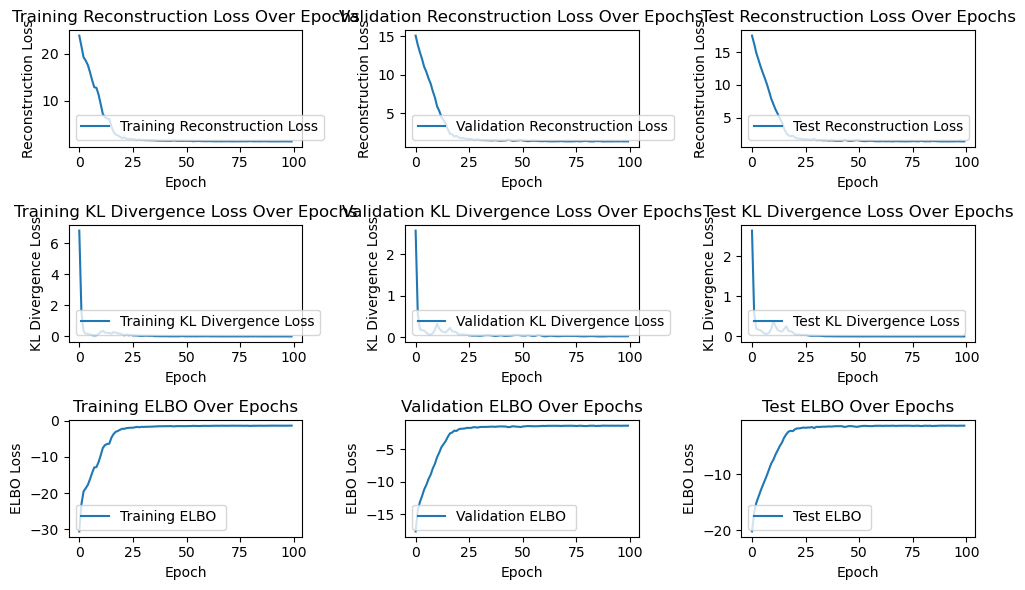

In [21]:
import matplotlib.pyplot as plt

# Assuming valid_rec, valid_kl, and valid_elbo are lists containing your validation losses

# Plot settings
plt.figure(figsize=(10, 6))

# Training Losses
# Subplot for Training Reconstruction Loss
plt.subplot(3, 3, 1)
plt.plot(train_rec, label='Training Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Training Reconstruction Loss Over Epochs')
plt.legend(loc='lower left')

# Subplot for Training KL Divergence Loss
plt.subplot(3, 3, 4)
plt.plot(train_kl, label='Training KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence Loss')
plt.title('Training KL Divergence Loss Over Epochs')
plt.legend(loc='lower left')

# Subplot for Training ELBO Loss
plt.subplot(3, 3, 7)
plt.plot(train_elbo, label='Training ELBO ')
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.title('Training ELBO Over Epochs')
plt.legend(loc='lower left')

# Validation Losses
# Subplot for Validation Reconstruction Loss
plt.subplot(3, 3, 2)
plt.plot(valid_rec, label='Validation Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Validation Reconstruction Loss Over Epochs')
plt.legend(loc='lower left')

# Subplot for Validation KL Divergence Loss
plt.subplot(3, 3, 5)
plt.plot(valid_kl, label='Validation KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence Loss')
plt.title('Validation KL Divergence Loss Over Epochs')
plt.legend(loc='lower left')

# Subplot for Validation ELBO Loss
plt.subplot(3, 3, 8)
plt.plot(valid_elbo, label='Validation ELBO ')
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.title('Validation ELBO Over Epochs')
plt.legend(loc='lower left')

# Test Losses
# Subplot for Test Reconstruction Loss
plt.subplot(3, 3, 3)
plt.plot(test_rec, label='Test Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Test Reconstruction Loss Over Epochs')
plt.legend(loc='lower left')

# Subplot for Test KL Divergence Loss
plt.subplot(3, 3, 6)
plt.plot(test_kl, label='Test KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence Loss')
plt.title('Test KL Divergence Loss Over Epochs')
plt.legend(loc='lower left')

# Subplot for Test ELBO Loss
plt.subplot(3, 3, 9)
plt.plot(test_elbo, label='Test ELBO ')
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.title('Test ELBO Over Epochs')
plt.legend(loc='lower left')

# Show the plots
plt.tight_layout()
plt.show()

In [22]:
rec_x_test_ = inference(vae, test_data_loader, USE_CUDA)
# rec_x_test, _ = inference(vae, test_data_loader, USE_CUDA)
print(f'Reconstruct data of size {rec_x_test_.shape}.')

Reconstruct data of size (600, 35).


#### First, we would like to see the difference between the best model and the last model

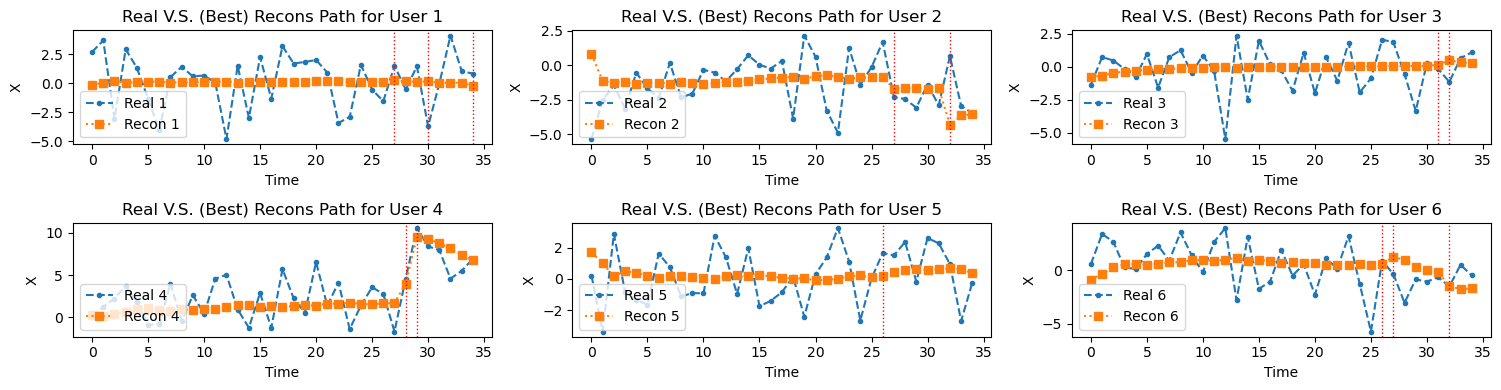

In [23]:
import matplotlib.pyplot as plt

num_individuals = 6

assert num_individuals < N, f'Can not plot {num_individuals} paths when N is set as {N}'
# Plot settings
plt.figure(figsize=(15, 4))  # Adjusting the size for six subplots

for i in range(num_individuals):
    plt.subplot(2, 3, i+1)
    plt.plot(X_test[i, 1:], label=f'Real {i+1}', marker='.', linestyle='dashed')
    # plt.plot(X_test_0[i, 1:], label=f'Real when no intervention {i+1}', marker='.', linestyle='dashed')
    plt.plot(rec_x_test_[i, :], label=f'Recon {i+1}', marker='s', linestyle='dotted')
    # plt.plot(rec_x_test_0.detach().numpy()[i, :], label=f'Recon when no intervention {i+1}', marker='o', linestyle='dotted')
    intervention_indices = np.where(D_test[i] != 0)[0]  # Find indices where intervention is not zero
    for idx in intervention_indices:
        plt.axvline(x=idx, color='r', linestyle=':', linewidth=1)  # Plot a vertical line at each intervention index
    plt.xlabel('Time')
    plt.ylabel('X')
    plt.title(f'Real V.S. (Best) Recons Path for User {i+1}')
    plt.legend(loc='lower left')

# Show the plots
plt.tight_layout()
plt.show()


#### Since this is only mean estimation, we can plot the model-based estimation of coverage

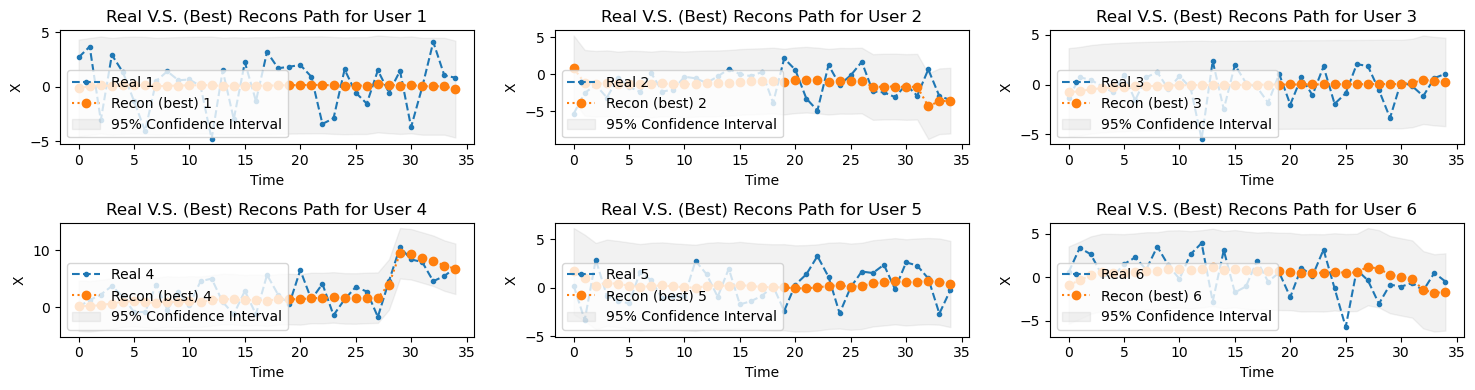

In [24]:
import matplotlib.pyplot as plt

num_individuals = 6

rec_x_test_upper = rec_x_test_ + 1.96 * torch.sqrt(vae.decoder.log_variance.exp()).detach().cpu().numpy()
rec_x_test_lower = rec_x_test_ - 1.96 * torch.sqrt(vae.decoder.log_variance.exp()).detach().cpu().numpy()


assert num_individuals < N, f'Can not plot {num_individuals} paths when N is set as {N}'
# Plot settings
plt.figure(figsize=(15, 4))  # Adjusting the size for six subplots

for i in range(num_individuals):
    plt.subplot(2, 3, i+1)
    time_index = np.arange(rec_x_test_[i, :].shape[0])
    
    plt.plot(X_test[i, 1:], label=f'Real {i+1}', marker='.', linestyle='dashed')
    # plt.plot(rec_x_test.detach().numpy()[mixture_index[i], :], label=f'Recon {mixture_index[i]+1}', marker='s', linestyle='dotted')
    plt.plot(rec_x_test_[i, :], label=f'Recon (best) {i+1}', marker='o', linestyle='dotted')
    # plt.plot(X_test_0[i, 1:], label=f'Recon with no intervention{i+1}', marker='s', linestyle='dotted')
    
    plt.fill_between(time_index, rec_x_test_lower[i, :], rec_x_test_upper[i, :], color='gray', alpha=0.1, label='95% Confidence Interval')
    plt.xlabel('Time')
    plt.ylabel('X')
    plt.title(f'Real V.S. (Best) Recons Path for User {i+1}')
    plt.legend(loc='lower left')

# Show the plots
plt.tight_layout()
plt.show()


### Now let's load the test dataset to check the predictive results

In [25]:
X_test_np, X_test0_np, D_test_np, Z_test_np = np.load(f'./data/x_test_{global_seed}.npy'), np.load(f'./data/x_test0_{global_seed}.npy'), np.load(f'./data/d_test_{global_seed}.npy'), np.load(f'./data/z_test_{global_seed}.npy')

print(f'X_test of shape {X_test_np.shape}, D_test of shape {D_test_np.shape} and Z_test of shape {Z_test_np.shape}')

X_test of shape (1000, 41, 50), D_test of shape (1000, 41) and Z_test of shape (1000, 5)


In [26]:
test_dataset_, test_dataset_0 = CustomDataset(X_test_np, D_test_np, Z_test_np), CustomDataset(X_test0_np, np.zeros_like(D_test_np), Z_test_np)
test_data_loader_, test_data_loader_0 = DataLoader(test_dataset_, batch_size=B_size), DataLoader(test_dataset_0, batch_size=B_size)

In [27]:
predict_x_test = predict(vae, test_data_loader_, USE_CUDA)
# predict_x_test_0 = predict(vae, test_data_loader_0, USE_CUDA)
print(f'Reconstruct data of size {predict_x_test.shape}.')

Reconstruct data of size (1000, 41, 50).


In [28]:
predict_x_test_mean = np.mean(predict_x_test, axis=-1)
# predict_x_test_median = np.median(predict_x_test, axis=-1)
X_test_np_mean = np.mean(X_test_np[:], axis=-1)
# X_test_np_median = np.median(X_test_np[:], axis=-1)
X_test0_np_mean = np.mean(X_test0_np[:], axis=-1)
X_test_np_mean[:, 0].shape

(1000,)

In [29]:
from sklearn.metrics import mean_squared_error

for i in range(5):
    mse_loss = mean_squared_error(X_test_np_mean[:, -5+i:], predict_x_test_mean[:, -5+i:])
    print(f'loss over the T + {i+1} time series is {mse_loss}')

loss over the T + 1 time series is 46.50119214074304
loss over the T + 2 time series is 56.32685813990253
loss over the T + 3 time series is 58.181990124593625
loss over the T + 4 time series is 57.668383886762726
loss over the T + 5 time series is 56.72668196983439


In [30]:
from sklearn.metrics import mean_squared_error

for i in range(5):
    mse_loss = np.median(np.abs(X_test_np_mean[:, -5+i:] - predict_x_test_mean[:, -5+i:]))
    print(f'loss over the T + {i+1} time series is {mse_loss}')

loss over the T + 1 time series is 2.5717826137437947
loss over the T + 2 time series is 3.1431148908250695
loss over the T + 3 time series is 3.2473957123097215
loss over the T + 4 time series is 3.26794137088059
loss over the T + 5 time series is 3.3228097639991026


In [31]:
res = X_test_np_mean[:, -5+i:] - predict_x_test_mean[:, -5+i:]
res.shape

(1000, 1)

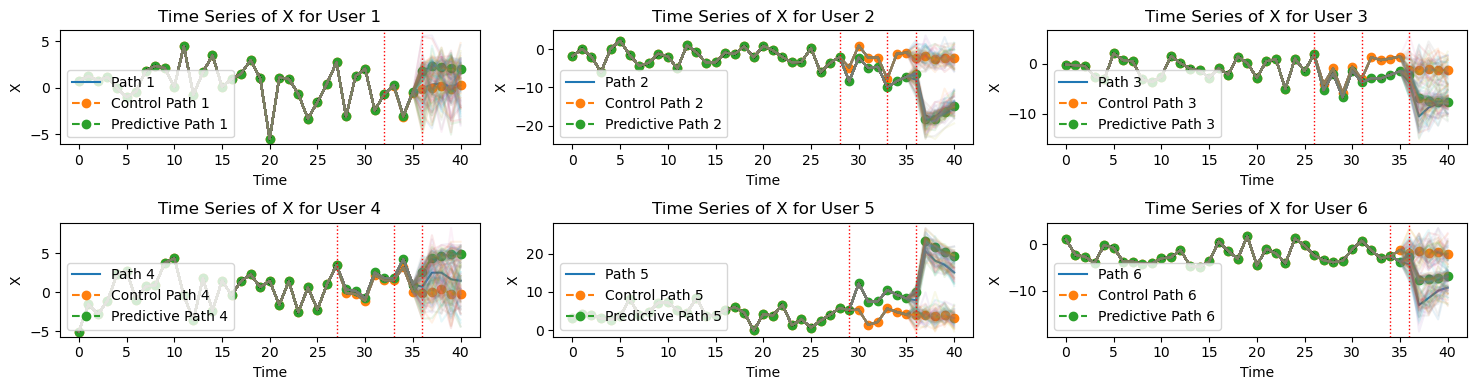

In [32]:
plt.figure(figsize=(15, 4))  # Adjust the size of the entire figure

# Ensure num_individuals is less than N
num_individuals = 6
# assert num_individuals <= N, f'Cannot plot {num_individuals} paths when N is set as {N}'

for i in range(num_individuals):
    plt.subplot(2, 3, i+1)  # Creates subplot in a 3x2 grid
    plt.plot(X_test_np_mean[i, :], label=f'Path {i+1}')
    plt.plot(X_test0_np_mean[i, :], label=f'Control Path {i+1}', marker='o', linestyle='dashed')
    plt.plot(predict_x_test_mean[i, :], label=f'Predictive Path {i+1}', marker='o', linestyle='dashed')
    for j in range(X_test_np.shape[-1]):
        plt.plot(predict_x_test[i, :, j], alpha=0.1)
        plt.plot(X_test0_np[:][i, :, j], alpha=0.1)
        plt.plot(X_test_np[:][i, :, j], alpha=0.1)

    # Plot intervention points
    intervention_indices = np.where(D_test_np[i] != 0)[0]  # Find indices where intervention is not zero
    for idx in intervention_indices:
        plt.axvline(x=idx, color='r', linestyle=':', linewidth=1)  # Plot a vertical line at each intervention index

    plt.xlabel('Time')
    plt.ylabel('X')
    plt.title(f'Time Series of X for User {i+1}')
    plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [33]:
torch.sqrt(vae.decoder.log_variance.exp())

tensor(2.2646, device='cuda:0', grad_fn=<SqrtBackward0>)

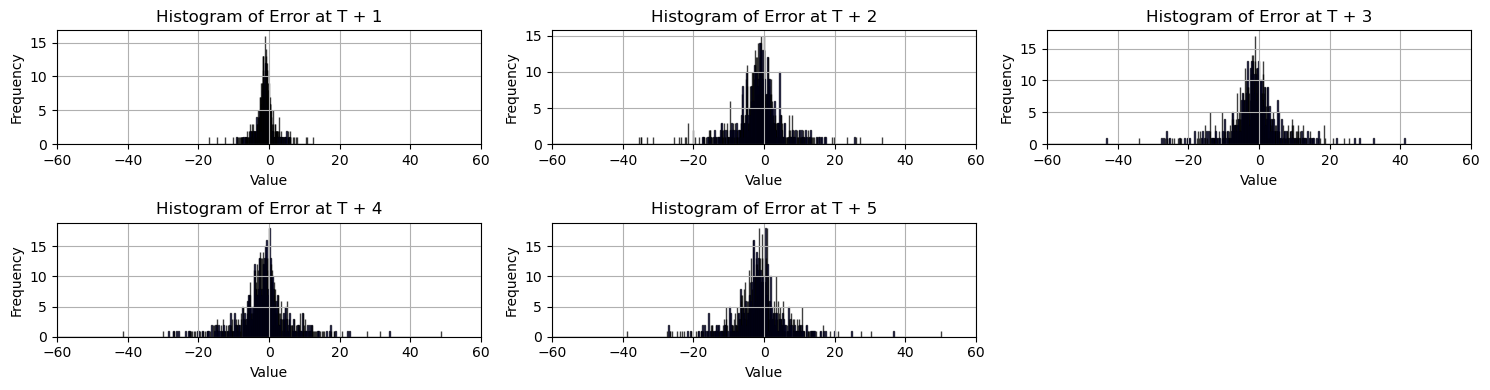

In [34]:
error_mean = X_test_np_mean - predict_x_test_mean

plt.figure(figsize=(15, 4))

x_min, x_max = -60, 60

for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.hist(error_mean[:, -5+i], bins=1000, alpha=0.75, color='blue', edgecolor='black', )
    plt.title(f'Histogram of Error at T + {i+1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.xlim(x_min, x_max)
    plt.grid(True)


plt.tight_layout()
plt.show()